# Using LMS IP on Pynq
This notebook demonstrates how to use the LMS filtering IP (unrolled int32 version) and verifies that it produces the expected results by comparing to a Python implementation.

For a demonstration of using the trace analyzer with this IP, see the `traceExample` notebook.

> Note: The constant `IDENTITY` is used widely as a means to treat integers as fixed-point values. The reason for this is that the Pynq interface only supports passing `np.int32` values, but the LMS algorithm is generally defined in terms of decimal values.

In [4]:
from pynq import Overlay, DefaultIP, allocate
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12,5)

In [5]:
plt.rcParams['figure.figsize']

[12.0, 5.0]

In [6]:
overlay= Overlay('/home/xilinx/pynq/overlays/lms/lms.bit')

In [7]:
MU_OFFSET = 0x10
DELTA_OFFSET = 0x18
IDENTITY = pow(2, 14)

mu = 1*IDENTITY
delta = 1e-3*IDENTITY

overlay.LMS_DMA.lms.write(MU_OFFSET, int(mu))
overlay.LMS_DMA.lms.write(DELTA_OFFSET, int(delta))

In [8]:
print(overlay.LMS_DMA.lms.read(DELTA_OFFSET))
print(overlay.LMS_DMA.lms.read(MU_OFFSET))

16
16384


In [9]:
test_ir = np.array([
-0.058158606314549964,
-0.11179499610251085,
-0.06955371490925417,
0.1277783378304197,
0.38326899688464383,
0.5020701199449168,
0.38326899688464383,
0.1277783378304197,
-0.06955371490925417,
-0.11179499610251085,
-0.058158606314549964,
])

n = 1000

x = allocate(shape=n, dtype=np.int32)
y = allocate(shape=n, dtype=np.int32)
yhat = allocate(shape=n, dtype=np.int32)
L = len(test_ir)
SNR = 1000
SeqLen = n - L + 1

x_np = np.random.normal(0, 0.01, SeqLen+L-1)
y_np = np.zeros(SeqLen)
for samp in range(SeqLen):
    y_np[samp] = x_np[samp:samp+L]@test_ir + np.random.normal(0,1/SNR)
    
for s in range(SeqLen):
    x[s] = int(x_np[s]*IDENTITY)
    y[s] = int(y_np[s]*IDENTITY)
    yhat[s] = 1

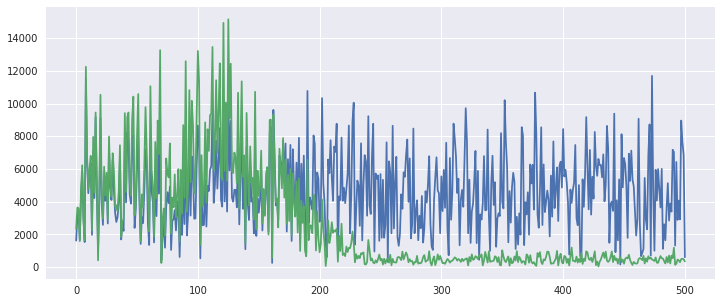

In [10]:
plt.plot(np.abs(np.fft.rfft(x)))
plt.plot(np.abs(np.fft.rfft(y)))

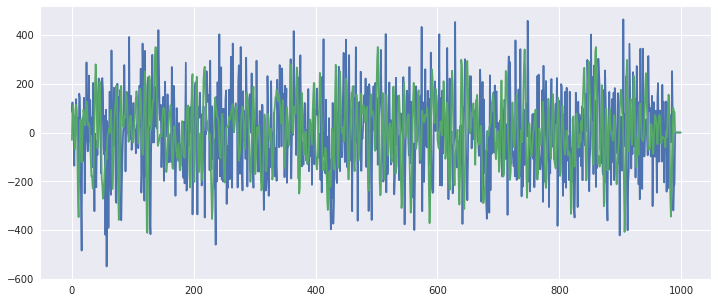

In [11]:
plt.plot(x)
plt.plot(y)

# Time in Hardware

In [12]:
xdma = overlay.LMS_DMA.x_dma
ydma = overlay.LMS_DMA.y_dma

> NOTE: LMS IP does not clear its weights between buffers, so do not use the `%%timit` macro, or final results will be incorrect because IP is not reset between runs. To run the next cell for a second time, re-load the overlay first.

In [13]:
%%time
xdma.sendchannel.transfer(x[L:])
ydma.sendchannel.transfer(y)
ydma.recvchannel.transfer(yhat)
xdma.sendchannel.wait()
ydma.recvchannel.wait()

CPU times: user 2.06 ms, sys: 0 ns, total: 2.06 ms
Wall time: 2.26 ms


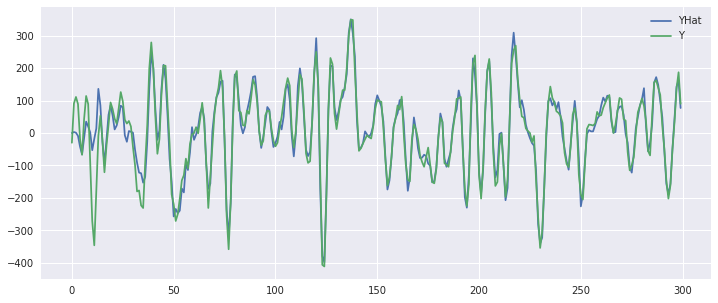

In [14]:
max = 300
#plt.plot(x[:max]/np.max(x[:max]))
plt.plot(yhat[:max])
plt.plot(y[:max])
plt.legend(["YHat", "Y"])

In [23]:
hw_mses = np.square(y-yhat)

# Time in Software

In [14]:
class NLMS:
    """ NLMS filter class
        Arguments:
            L     : length of filter in samples
            mu    : learning rate of filter
            delta : factor to add for numerical stability
            
        NOTE: This version uses integers to emulate hardware
            
    """
    def __init__(self, L, mu, delta):
        self.w = np.zeros(L, dtype=np.int32)
        self.mu = mu
        self.delta = delta
        self.identity = pow(2,14)
        
    def process(self, X, y):
        yhat = (np.dot(self.w, X.astype(np.int64))//self.identity).astype(np.int32)
        e = y-yhat
        nu = self.mu / (self.delta + np.dot(X, X)/self.identity)
        wc = ((nu * e) * X / self.identity).astype(np.int32)
        self.w += wc
        mse = e**2
        return mse, yhat

In [15]:
filt = NLMS(11, mu, delta)

In [16]:
es_nlms   = np.zeros(y.shape)
yhat_nlms   = np.zeros(y.shape)

In [17]:
%%time
for i in range(SeqLen):
    es_nlms[i], yhat_nlms[i] = filt.process(x[i:i+L], y[i])

CPU times: user 1.45 s, sys: 91.7 ms, total: 1.55 s
Wall time: 1.43 s


## Compare HW & SW Times
> Note: Wall time was used as the measurement of choice. The reason for this is that walltime is what is important to the user. Also, the hardware implementation will not show any system time used, but because `user` time is summed across cores, it is impossible to isolate `sys` time using `wall time - user`.

In [19]:
1430 / 2.24

638.3928571428571

The results show a ~600x speedup by moving to hardware. This should be taken with a grain of salt, however because the software implementation has some extra overhead in how it is passed data.

## Compare Losses between HW & SW

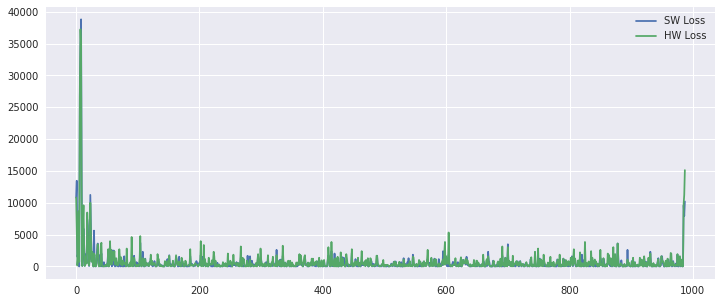

In [29]:
plt.plot(es_nlms[:n-L-1])
plt.plot(hw_mses[:n-L-1])
plt.legend(["SW Loss", "HW Loss"])

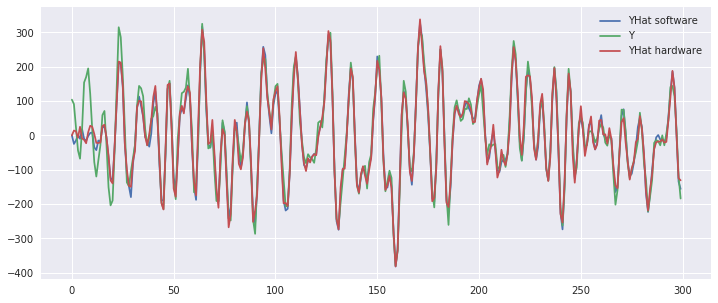

In [30]:
plt.plot((yhat_nlms)[:max])
plt.plot(y[:max])
plt.plot(yhat[:max])
plt.legend(['YHat software', 'Y', 'YHat hardware'])